<h1>Import Necessary Libraries</h1>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Reshape, Dense 
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Conv2D ,Conv2DTranspose
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam

import numpy as np
from PIL import Image
from tqdm import tqdm

import os 
import time
import matplotlib.pyplot as plt

In [37]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        print("Using GPU")
    except RuntimeError as e:
        print(e)

Using GPU


In [46]:
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


<h1>Preprocessing</h1>

In [3]:
data_path = 'utkcropped/'

In [25]:
# load the dataset from the directory using a batch size of 128
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_path, 
    label_mode=None, 
    color_mode='rgb',
    batch_size=128,
    image_size=(128, 128),
    shuffle=True
)

Found 23709 files belonging to 1 classes.


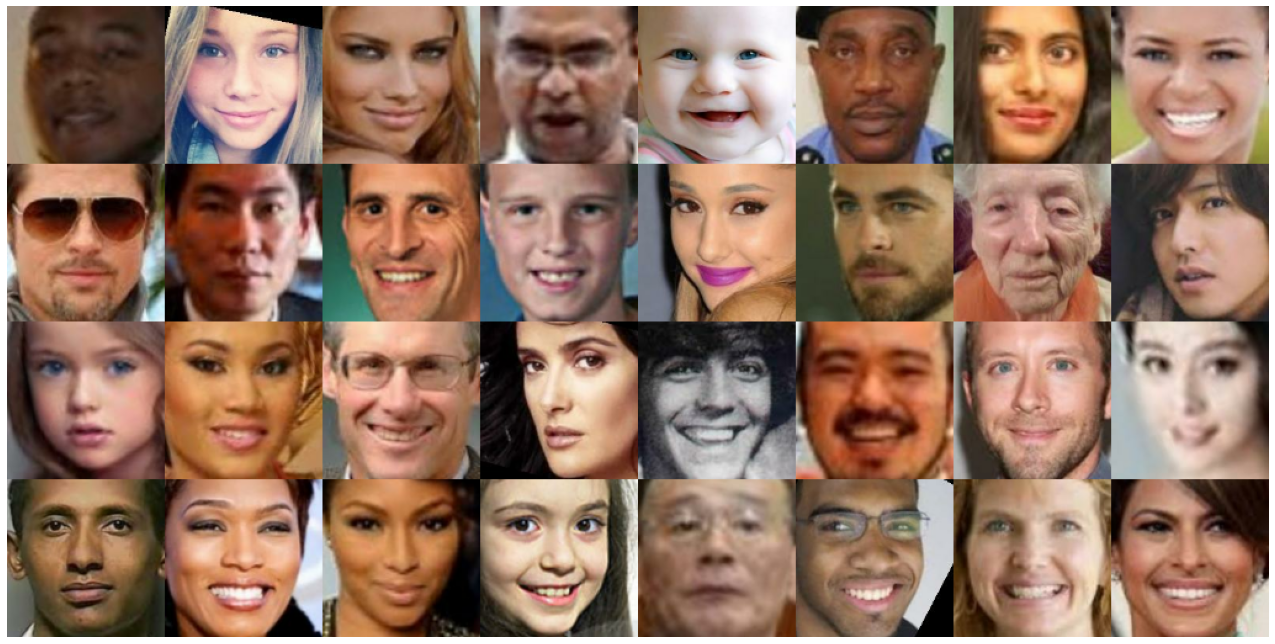

In [28]:
def plot_batch(batch, rows, cols):
    
    index = 0
    face_size = batch.shape[1]
    width = face_size * cols
    height = face_size * rows
    figure = np.zeros(shape=(height, width, 3))
    
    for row in range(rows):
        for col in range(cols):
            figure[
                row * face_size: (row + 1) * face_size,
                col * face_size: (col + 1) * face_size,
            ] = batch[index]
            
            index += 1
    
    plt.figure(figsize=(2.9 * cols, 2.9 * rows))
    plt.imshow(figure)
    plt.axis("off")
    

batch_image = next(iter(train_ds.take(1)))
batch_image = batch_image.numpy()/255

plot_batch(batch_image, 4, 8)

In [29]:
train_ds = train_ds.map(lambda x: (x / 255.0)) # convert the dataset to a range of [0,1]

<h1>Define Model</h1>

In [31]:
latent_dim = 2048
intitializer = tf.keras.initializers.he_normal()

In [43]:
encoder_inputs = tf.keras.layers.Input(shape=(128, 128, 3),name="encoder_input")
                      
x = tf.keras.layers.InputLayer(input_shape=(128,128,3))(encoder_inputs)

#block - 1
x = tf.keras.layers.Conv2D(32,3,strides=(2,2),padding='same',kernel_initializer=intitializer)(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x) #64,64,32

# block - 2
x = tf.keras.layers.Conv2D(64,3,strides=(2,2),padding='same',kernel_initializer=intitializer)(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x) #32,32,64

# block - 3
x = tf.keras.layers.Conv2D(128,5,strides=(2,2),padding='same',kernel_initializer=intitializer)(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x) #16,16,128

# block - 4
x = tf.keras.layers.Conv2D(128,5,strides=(2,2),padding='same',kernel_initializer=intitializer)(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x) #8,8,128
x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dense(8*8*128,activation='relu',kernel_initializer=intitializer)(x)
z_mean = tf.keras.layers.Dense(latent_dim,activation='linear',kernel_initializer=intitializer)(x) # mean
z_log_var = tf.keras.layers.Dense(latent_dim,activation='linear',kernel_initializer=intitializer)(x) # log(variance)

encoder = tf.keras.models.Model(encoder_inputs,[z_mean,z_log_var])
encoder.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            multiple             0           encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 64, 64, 32)   896         input_3[1][0]                    
__________________________________________________________________________________________________
leaky_re_lu_14 (LeakyReLU)      (None, 64, 64, 32)   0           conv2d_8[0][0]                   
_______________________________________________________________________________________

In [44]:
decoder_input = tf.keras.layers.Input(shape=(latent_dim,), name="decoder_input")

#block - 1
x = tf.keras.layers.Dense(units=8*8*128, activation='relu',kernel_initializer=intitializer)(decoder_input)
x = tf.keras.layers.Reshape(target_shape=(8,8,128))(x)

#block - 2
x = tf.keras.layers.Conv2DTranspose(128,5,strides=2,padding='same',kernel_initializer=intitializer)(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x) #16,16,128

#block - 3
x = tf.keras.layers.Conv2DTranspose(64,5,strides=2,padding='same',kernel_initializer=intitializer)(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x) # 32,32,64

#block - 4
x = tf.keras.layers.Conv2DTranspose(32,3,strides=2,padding='same',kernel_initializer=intitializer)(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x) # 64,64,32


decoder_img = tf.keras.layers.Conv2DTranspose(3,3,strides=2,padding='same',activation='sigmoid',kernel_initializer=intitializer)(x) # 128,128,3

decoder = tf.keras.models.Model(decoder_input, decoder_img, name="decoder_model")
decoder.summary()

Model: "decoder_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2048)]            0         
_________________________________________________________________
dense_11 (Dense)             (None, 8192)              16785408  
_________________________________________________________________
reshape_2 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 16, 16, 128)       409728    
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 32, 32, 64)        204864    
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 32, 32, 64)      

In [45]:
class CVAE(keras.Model):

    def __init__(self,latent_dim,encoder,decoder,**kwargs):
        super(CVAE,self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def sampling(self,z_mean,z_log_variance):
        latent_shape = (tf.shape(z_mean)[0],tf.shape(z_mean)[1])
        eps = tf.random.normal(shape=latent_shape)
        return z_mean + tf.exp(0.5*z_log_variance)*eps

    def train_step(self,data):

        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            mean, logvar = encoder(data)
            z = self.sampling(mean,logvar)
            x_logit = self.decoder(z)
      
            reconstruction_loss = tf.reduce_mean(keras.losses.MSE(data, x_logit))
            reconstruction_loss*= 128*128

            KL_div_loss = tf.math.reduce_mean(-0.5*tf.math.reduce_sum(1 + logvar - tf.square(mean) - tf.exp(logvar),axis=1))

            loss = reconstruction_loss + KL_div_loss

        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
              "total loss": loss,
              "reconstruction loss": reconstruction_loss,
              "kl divergence loss": KL_div_loss,
            }


In [ ]:
with tf.device('/GPU:0'):
    cvae = CVAE(latent_dim,encoder,decoder)
    cvae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
    history = cvae.fit(train_ds, epochs=200, batch_size=128)

<h1>Save Weights</h1>

In [50]:
cvae.encoder.save_weights('Weights/encoder_weights.h5')
cvae.decoder.save_weights('Weights/decoder_weights.h5')